# Child Poverty Classification for United States Counties

Wyatt Saltzman and Landon Wood  
Dr. Larson  
CS 7324  
October 29, 2023  

## Load, Split, and Balance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# Read in dataset and confirm df is populated
data = 'acs2017_census_tract_data.csv'
df = pd.read_csv(data)
print(df.shape)
df.head()

(74001, 37)


,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [2]:
# Check for duplicates
duplicates = df[df['TractId'].duplicated(keep=False)]
print("Number of duplicates in df:", duplicates.size)

# Drop TractId column, as it's uneccesary for classification
df = df.drop('TractId', axis=1)
df.head()

Number of duplicates in df: 0


,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,1.2,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [3]:
# Look at missing values
print(df.isna().sum())
print('Number of rows with missing values:', df.isnull().any(axis=1).sum())

State                  0
County                 0
TotalPop               0
Men                    0
Women                  0
Hispanic             696
White                696
Black                696
Native               696
Asian                696
Pacific              696
VotingAgeCitizen       0
Income              1116
IncomeErr           1116
IncomePerCap         745
IncomePerCapErr      745
Poverty              842
ChildPoverty        1110
Professional         811
Service              811
Office               811
Construction         811
Production           811
Drive                801
Carpool              801
Transit              801
Walk                 801
OtherTransp          801
WorkAtHome           801
MeanCommute          946
Employed               0
PrivateWork          811
PublicWork           811
SelfEmployed         811
FamilyWork           811
Unemployment         810
dtype: int64
Number of rows with missing values: 1283


In [4]:
import copy

df_dropped = copy.deepcopy(df) # Create deep copy of df to avoid overwriting
df_dropped.dropna(axis='index',inplace=True)

# Reset index of df to keep order consistent
df_dropped.reset_index(drop=True, inplace=True)

print('df shape before dropping:', df.shape)
print('df shape after dropping:', df_dropped.shape)
print(df_dropped.isna().sum())
print('Number of rows with missing values:', df_dropped.isnull().any(axis=1).sum())

df shape before dropping: (74001, 36)
df shape after dropping: (72718, 36)
State               0
County              0
TotalPop            0
Men                 0
Women               0
Hispanic            0
White               0
Black               0
Native              0
Asian               0
Pacific             0
VotingAgeCitizen    0
Income              0
IncomeErr           0
IncomePerCap        0
IncomePerCapErr     0
Poverty             0
ChildPoverty        0
Professional        0
Service             0
Office              0
Construction        0
Production          0
Drive               0
Carpool             0
Transit             0
Walk                0
OtherTransp         0
WorkAtHome          0
MeanCommute         0
Employed            0
PrivateWork         0
PublicWork          0
SelfEmployed        0
FamilyWork          0
Unemployment        0
dtype: int64
Number of rows with missing values: 0


In [5]:
# Encode all string data as integers
# Note: label encoding should not be used for state and county in general; these should be one-hot encoded.
# However, the lab specifies to only encode as ints for now.
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_dropped['State'] = label_encoder.fit_transform(df_dropped['State'])
df_dropped['County'] = label_encoder.fit_transform(df_dropped['County'])

print('State values after label encoding:', df_dropped['State'].unique())
print('County values after label encoding:', df_dropped['County'].unique())

State values after label encoding: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48
 49 50 51 39]
County values after label encoding: [  89   97  108 ... 1818 1929 1938]


At this point, we are actually going to drop the County column. This is for a couple of reasons. First, we do not feel that County will be as strong of a predictor for child poverty rates than the other numerical data in the dataset. Additionally, the County variable presents challenges when encoding the data. Later in the lab, when we one-hot encoded categorical data, we found that one-hot encoding the County column in the train and test data, not all counties were present in both of these inputs. This is a major problem because it results in the one-hot encoding take up a different amount of space, resulting in different numbers of columns in the train and test data. This makes our neural network's "feedforward()" function fail, as the two matrices inputted must have equal column dimensions for matrix multiplication to occur. Given these challenges, we feel justified removing the County column.

In [6]:
# Drop County column
df_dropped = df_dropped.drop('County', axis=1)
df_dropped

,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,0,1845,899,946,2.4,86.3,5.2,0.0,1.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,0,2172,1167,1005,1.1,41.6,54.5,0.0,1.0,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,0,3385,1533,1852,8.0,61.4,26.5,0.6,0.7,0.4,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,0,4267,2001,2266,9.6,80.3,7.1,0.5,0.2,0.0,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,0,9965,5054,4911,0.9,77.5,16.4,0.0,3.1,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72713,39,6011,3035,2976,99.7,0.3,0.0,0.0,0.0,0.0,...,0.5,0.0,3.6,26.9,1576,59.2,33.8,7.0,0.0,20.8
72714,39,2342,959,1383,99.1,0.9,0.0,0.0,0.0,0.0,...,0.0,0.0,1.3,25.3,666,58.4,35.4,6.2,0.0,26.3
72715,39,2218,1001,1217,99.5,0.2,0.0,0.0,0.2,0.0,...,3.4,0.0,3.4,23.5,560,57.5,34.5,8.0,0.0,23.0
72716,39,4380,1964,2416,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.1,1062,67.7,30.4,1.9,0.0,29.5


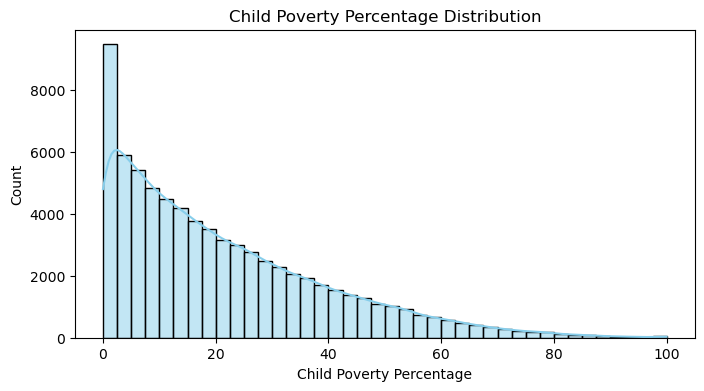

In [7]:
plt.figure(figsize=(8,4))
sns.histplot(df_dropped['ChildPoverty'], bins=40, kde=True, color='skyblue')
plt.xlabel('Child Poverty Percentage')
plt.ylabel('Count')
plt.title('Child Poverty Percentage Distribution')
plt.show()

Since we are predicting the ChildPoverty variable, we want to use realistic thresholds for defining the various levels of child poverty. According to an article from the United States Census Bureau titled "[Poverty Rate varies by Age Groups](https://www.census.gov/library/stories/2022/10/poverty-rate-varies-by-age-groups.html)," "the national child poverty rate was 16.9% but there was considerable variation among states, ranging from 8.1% to 27.7%." Below is a figure that comes from this article which outlines child poverty by state:  

![image](child_poverty_by_state_2021.avif)

We can use the categories present in this image as realistic thresholds for our quantization. Although we could not find information about subsidies that the government might provide for areas with high child poverty levels, we feel that using the Census Bureau's thresholds makes sense.

This represents child poverty by state, but we can extend the thresholds to be by county. With a national average of 16.9%, we can define the thresholds as follows:

- Low: 0 - 11%
- Average: 11 - 18%
- High: 18 - 22%
- Very High - 22% - 100%


In [8]:
# Define the bin edges and labels for the categories
bin_edges = [0, 11, 18, 22, 100]
bin_labels = [0, 1, 2, 3]

df_processed = df_dropped.copy()

# Use the cut function to create the categorical column
df_processed['ChildPoverty'] = pd.cut(df_processed['ChildPoverty'], bins=bin_edges, labels=bin_labels, include_lowest=True)

child_poverty_counts = df_processed['ChildPoverty'].value_counts()
num_records = 72718

print(child_poverty_counts)
print('Percentage of child poverty for each category:')
# print percentages of child poverty for each category rounded to 2 decimal places
print(np.round(child_poverty_counts / num_records, 2))


3    28498
0    27654
1    11261
2     5305
Name: ChildPoverty, dtype: int64
Percentage of child poverty for each category:
3    0.39
0    0.38
1    0.15
2    0.07
Name: ChildPoverty, dtype: float64


In [9]:
# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X = df_processed.drop('ChildPoverty', axis=1).values
y = df_processed['ChildPoverty'].astype('uint8').values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(58174, 34)
(58174,)
(14544, 34)
(14544,)


In [10]:
# use smotenc to balance the dataset
from imblearn.over_sampling import SMOTENC

cateogrical_features = [0]
sm = SMOTENC(categorical_features=cateogrical_features)

X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print('Class balance after SMOTENC:', np.bincount(y_train_smote))
print(X_train_smote.shape)
print(y_train_smote.shape)

Class balance after SMOTENC: [22797 22797 22797 22797]
(91188, 34)
(91188,)


In [11]:
print(np.unique(X_train_smote[:, 0]))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.]


We chose to use SMOTE (Synthetic Minority Over-sampling Technique) to balance our data because our dataset exhibited a significant class imbalance, with a notably smaller number of instances in the minority classes. In such imbalanced datasets, standard machine learning models may struggle to accurately classify minority classes due to the limited number of examples available for training. SMOTE provides an effective solution by creating synthetic samples for the minority classes, effectively expanding the dataset and making it more balanced. This technique not only mitigates the risk of model bias towards the majority class but also enhances the model's ability to learn from all classes, ultimately leading to improved classification performance.

Balancing the dataset is typically done on the training set only, and not on the testing set. The reason for this is related to the objectives of model training and evaluation. Here's why:

1. **Training Set Balancing**:

   - Balancing the training set helps the machine learning model learn from all classes effectively, particularly when dealing with imbalanced data.
   - In an imbalanced dataset, the model can become biased toward the majority class. By balancing the training set, you ensure that the model is exposed to roughly equal amounts of data from each class, helping it learn the underlying patterns and relationships in all classes.

2. **Testing Set Unaltered**:

   - The testing set is intended to simulate how well your model will perform on real-world, unseen data.
   - Balancing the testing set would artificially alter the class distribution, which doesn't reflect the actual class distribution you would encounter in practice.
   - Balancing the testing set can lead to overly optimistic evaluation results because the model has been trained on a different class distribution.

3. **Realistic Evaluation**:

   - By keeping the testing set unaltered, you ensure that the model's performance evaluation reflects its ability to generalize to the actual, imbalanced distribution that you will encounter in real-world scenarios.
   - This realistic evaluation is crucial for understanding how well your model will perform in practice and making meaningful decisions about its deployment.

In summary, balancing is a preprocessing step that is applied to the training set to help the model learn effectively. The testing set should remain untouched to provide a realistic assessment of your model's performance under real-world class distribution conditions.

## Pre-processing and Two-Layer Perceptron

Now, we will define our two layer perceptron. We will be using the sample code provided in the class notebook "8a. Practical_NeuralNets with Bias".

In [12]:
 # Base two layer perceptron with vectorized back propagation
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    

In [13]:
# Add mini batching

from sklearn.metrics import accuracy_score
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
            
        for i in range(self.epochs):

            # adaptive learning rate
            # decrease at certain epochs
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                
                # simple momentum calculations
                
                rho_W1, rho_W2 = eta * gradW1, eta * gradW2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                
                # no need for momentum in bias 
                # these values need to change abruptly and 
                # do not influence sensitivity backward
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                
                # update previous parameters 
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                
                

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            
            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))
            
        return self
    

In [14]:
# Implement cross entropy loss
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3+1e-7)+(1-Y_enc)*np.log(1-A3+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C

        return gradW1, gradW2, gradb1, gradb2
        
    

In [15]:
# Add Glorot initialization to finalize TLP
class TLP_Vec_Mini_Cross_Glorot(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden)) 
        
        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    # get_params and set_params implemented to allow for usage of sklearn cross-validation functions
    def get_params(self, deep=True):
        return {
            'n_hidden': self.n_hidden,
            'C': self.l2_C,
            'epochs': self.epochs,
            'eta': self.eta,
            'alpha': self.alpha,
            'decrease_const': self.decrease_const,
            'decrease_iter': self.decrease_iter,
            'minibatches': self.minibatches,
            'shuffle': self.shuffle
            # Add other parameters here
        }
    
    def set_params(self, **params):
        # Set the parameters of the estimator
        for param, value in params.items():
            setattr(self, param, value)
        return self

This neural network contains the four requirements: vectorized gradient computation, mini batching, cross entropy loss, and  Glorot intialization. It also incorporates momentum in the "fit()" function. Now, let's try fitting and classifying the data:

In [16]:
# Helper function to print accuracies of nn classification
def print_accuracies(nn,X_train,y_train,X_test,y_test):
    
    yhat = nn.predict(X_train)
    print('Resubstitution accuracy:',accuracy_score(y_train,yhat))
    
    yhat = nn.predict(X_test)
    print('Validation accuracy:',accuracy_score(y_test,yhat))

In [17]:
# Parameter dictionary for neural network
vals = { 'n_hidden':50, 
         'C':0.1, 'epochs':100, 'eta':0.001,
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

In [18]:
smote_nn = TLP_Vec_Mini_Cross_Glorot(**vals)
%time smote_nn.fit(X_train_smote, y_train_smote, print_progress=10, XY_test=(X_test, y_test))
print_accuracies(smote_nn,X_train_smote,y_train_smote,X_test,y_test)

Epoch: 100/100

CPU times: total: 5min 30s
Wall time: 50.6 s
Resubstitution accuracy: 0.25179848225643725
Validation accuracy: 0.07687018701870187


25% and 7% for resubstitution and validation accuracies on the balanced data is obviously not great. However, given the lack of preprocessing steps at this point in the lab, we are not expecting great performance. Additionally, we are encouraged because we can see that our training is converging when we plot the cost function vs. number of epochs:

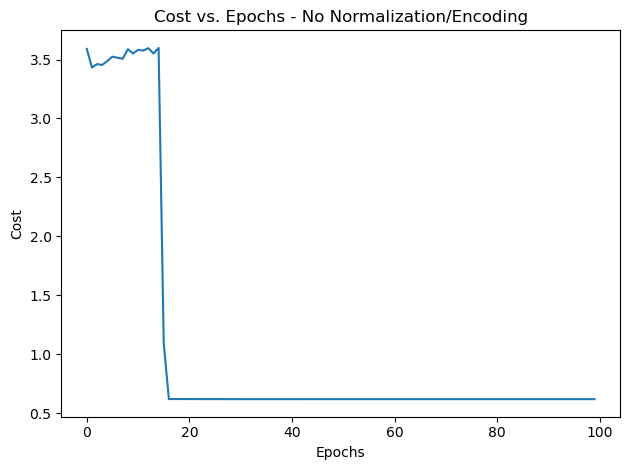

In [19]:
plt.plot(range(len(smote_nn.cost_)), smote_nn.cost_)
plt.title('Cost vs. Epochs - No Normalization/Encoding')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Now, we will perform the same steps as above, but we will normalize the continuous numeric feature data first, and see if that makes any difference in our classification performance:

In [20]:
# Normalize continuous numeric feature data with the balanced training data
from sklearn.preprocessing import StandardScaler# Exclude column corresponding to State

exclude_indices = [0]
columns_to_exclude = X_train_smote[:, exclude_indices]

# Normalize all other columns, as they are all continuous feature data
columns_to_normalize = np.delete(X_train_smote, exclude_indices, axis=1)

# Use scikit-learn to normalize
scaler = StandardScaler()
normalized_columns = scaler.fit_transform(columns_to_normalize)

# Combine the two columns back into one array
X_train_smote_norm = np.hstack((columns_to_exclude, normalized_columns))

# Now do the same thing, but on X_test
columns_to_exclude = X_test[:, exclude_indices]
columns_to_normalize = np.delete(X_test, exclude_indices, axis=1)
scaler = StandardScaler()
normalized_columns = scaler.fit_transform(columns_to_normalize)
X_test_norm = np.hstack((columns_to_exclude, normalized_columns))


print(X_train_smote_norm.shape)
print(X_test_norm.shape)

(91188, 34)
(14544, 34)


In [21]:
print(np.unique(X_train_smote[:, 0]))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.]


In [22]:
# Run TLP with normalized data and balanced training data

smote_nn_norm = TLP_Vec_Mini_Cross_Glorot(**vals)
%time smote_nn_norm.fit(X_train_smote_norm, y_train_smote, print_progress=10, XY_test=(X_test_norm, y_test))
print_accuracies(smote_nn_norm,X_train_smote_norm,y_train_smote,X_test_norm,y_test)

Epoch: 100/100

CPU times: total: 2min 2s
Wall time: 17.9 s
Resubstitution accuracy: 0.5992784138263807
Validation accuracy: 0.6529840484048405


Great, so normalizing the data made a huge difference in accuracy, jumping massively for both validation and resubstitution. Again, our training converges:

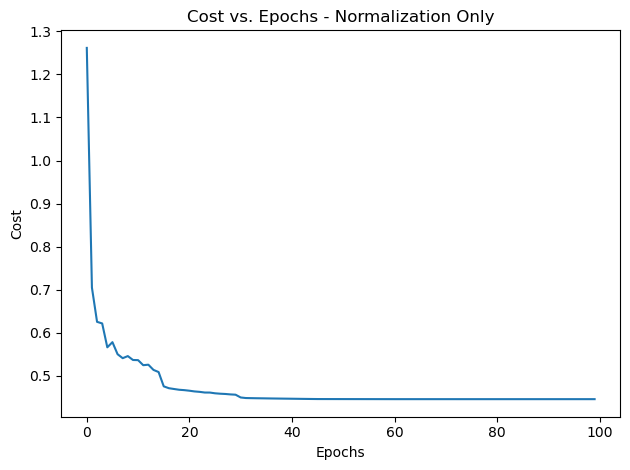

In [23]:
plt.plot(range(len(smote_nn_norm.cost_)), smote_nn_norm.cost_)
plt.title('Cost vs. Epochs - Normalization Only')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Next, we will perform the same process again, but this time we will also encode the categorical columns. It should be noted that we are making an important assumption: that train and test will both contain all possible state values after the split. As we discussed when we were dropping the County variable, we need the one-hot encoding to take up the same number of columns for our neural network's "feedforward()" function to work. We are fine making this assumption, as given the sample size, it is very likely that train and test will both have all states.

In [24]:
# Perform the same process as normalization above, specifying the first two columns to encode, encoding, and combining
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.simplefilter('ignore', FutureWarning)

indices = [0]
columns_to_encode = X_train_smote_norm[:, indices]
columns_to_exclude = np.delete(X_train_smote_norm, indices, axis=1)
encoder = OneHotEncoder(sparse=False)
one_hot_encoded_columns = encoder.fit_transform(columns_to_encode)
X_train_smote_norm_enc = np.hstack((one_hot_encoded_columns, columns_to_exclude))

# Repeat for X_test_norm
columns_to_encode = X_test_norm[:, indices]
columns_to_exclude = np.delete(X_test_norm, indices, axis=1)
encoder = OneHotEncoder(sparse=False)
one_hot_encoded_columns = encoder.fit_transform(columns_to_encode)
X_test_norm_enc = np.hstack((one_hot_encoded_columns, columns_to_exclude))

print(X_train_smote_norm_enc.shape)
print(X_test_norm_enc.shape)

(91188, 85)
(14544, 85)


In [25]:
smote_nn_norm_enc = TLP_Vec_Mini_Cross_Glorot(**vals)
%time smote_nn_norm_enc.fit(X_train_smote_norm_enc, y_train_smote, print_progress=10, XY_test=(X_test_norm_enc, y_test))
print_accuracies(smote_nn_norm_enc,X_train_smote_norm_enc,y_train_smote,X_test_norm_enc,y_test)

Epoch: 100/100

CPU times: total: 2min 31s
Wall time: 22.5 s
Resubstitution accuracy: 0.6919221827433434
Validation accuracy: 0.6887376237623762


Once again, we see an improvement in our classification accuracy when we also encode the categorical columns. Our training still converges:

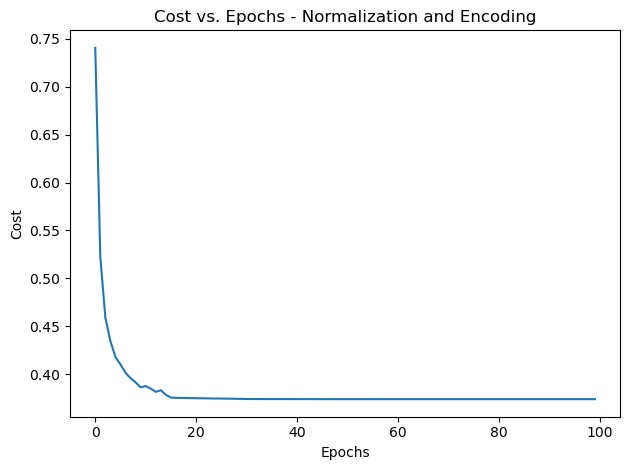

In [26]:
plt.plot(range(len(smote_nn_norm_enc.cost_)), smote_nn_norm_enc.cost_)
plt.title('Cost vs. Epochs - Normalization and Encoding')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

With each additional preprocessing step, our classification accuracy improved. Not normalizing or one-hot encoding any of the data performed significantly worse than when we did normalize or encode. The performance difference is very meaningful when we normalized; we saw a massive increase in accuracy, for both resubstitution and validation. The improvement was smaller when we also included encoding. Although it was a smaller increase, it was a tangible improvement for such a simple preprocessing step to take. These differences emphasize the importance of proper preprocessing, especially the importance of normalization. From class, we know that neural networks want normalized values, and when we did not normalize, we were basically doing much worse than even chance. Thankfully, moving forward, we will continue to use the normalized and encoded data.

Next, we will perform cross validations and statistical comparisons to see if our neural networks performances' are statistically different from one another. We will use sklearn's "cross_val_score" and "StratifiedShuffleSplit" to perform the cross validation, while sticking with "accuracy_score" for our evaluation metric:

In [27]:
# Use stratified shuffle splits and accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
my_scorer = make_scorer(accuracy_score)

train_size = 0.003
cv = StratifiedShuffleSplit(n_splits=10, train_size=train_size, test_size=1-train_size)

# Using the matching X_train with the same preprocessing steps
smote_nn_evals = cross_val_score(estimator=smote_nn, X=X_train_smote, y=y_train_smote, scoring=my_scorer, cv=cv)
smote_nn_norm_evals = cross_val_score(estimator=smote_nn_norm, X=X_train_smote_norm, y=y_train_smote, 
                                          scoring=my_scorer, cv=cv)
smote_nn_norm_enc_evals = cross_val_score(estimator=smote_nn_norm_enc, X=X_train_smote_norm_enc, y=y_train_smote, 
                                          scoring=my_scorer, cv=cv)


print(smote_nn_evals)
print(smote_nn_norm_evals)
print(smote_nn_norm_enc_evals)

[0.22952208 0.25802123 0.28071275 0.21402409 0.21203322 0.24631799
 0.28557444 0.26566573 0.25461145 0.27621405]
[0.37486663 0.39087059 0.39468735 0.34755541 0.32506187 0.32973657
 0.37036793 0.33212341 0.34800638 0.41901776]
[0.43128197 0.43634164 0.41407908 0.43813452 0.42380245 0.44885882
 0.42841115 0.39897707 0.42188858 0.45134466]


In [28]:
# Statistical test to determine if the models are different with 95% confidence.
# Option B from flipped module 3
def compare_models(model1_evals, model2_evals):
    t = 2.26 / np.sqrt(10)
    e = (1 - model1_evals) - (1 - model2_evals)
    stdtot = np.std(e)
    dbar = np.mean(e)
    comparison_range = (dbar - t*stdtot, dbar + t*stdtot)
    
    return comparison_range

In [29]:
# Get comparison range for each model comparison to see if they are different from each other.
comparison = compare_models(smote_nn_evals, smote_nn_norm_evals)
print(comparison)

comparison = compare_models(smote_nn_evals, smote_nn_norm_enc_evals)
print(comparison)

comparison = compare_models(smote_nn_norm_evals, smote_nn_norm_enc_evals)
print(comparison)

(0.09214527226448496, 0.12977410297612432)
(0.1547000921209229, 0.19938449238108447)
(0.04531559759592289, 0.08684961166547511)


Because 0 is not included in any of these ranges, we can conclude that each model is statistically different with 95% confidence. Given the sizeable difference in accuracies between each model after adding preprocessing steps, we expected them to be different from each other.

## Three Layer Perceptron

Now, we will extend our two-layer perceptron by adding a third layer. We will add support for saving and plotting the gradient magnitudes for each layer as well.

In [30]:
# three layer perceptron class
class ThreeLayerPerceptron(object):
    def __init__(self, n_hidden1=30, n_hidden2=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    def _initialize_weights(self):
        '''Initialize weights with small random numbers'''
        # Layer 1
        W1_num_elems = (self.n_features_)*self.n_hidden1
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden1, self.n_features_)
        b1 = np.zeros((self.n_hidden1, 1))

        # Layer 2
        W2_num_elems = (self.n_hidden1)*self.n_hidden2
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden2, self.n_hidden1)
        b2 = np.zeros((self.n_hidden2, 1))

        # Layer 3
        W3_num_elems = (self.n_hidden2)*self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden2)
        b3 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, b1, b2, b3
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        return expit(z)
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))
    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A4)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term

    def _feed_forward(self, X, W1, W2, W3, b1, b2, b3):
        '''Compute feedforward step'''
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        '''Compute gradient step using backpropagation'''
        # vectorized backpropagation
        V3 = -2*(Y_enc-A4)*A4*(1-A4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3
    
    def predict(self, X):
        '''Predict class labels'''
        _, _, _, _, _, _, A4 = self._feed_forward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

In [31]:
# Three layer perceptron with mini-batch and cooling and cross entropy loss and Glorot initialization
class ThreeLayerEnhanced(ThreeLayerPerceptron):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    # Glorot initialization
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden1 + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden1, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden2 + self.n_hidden1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden1)) 

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden2)) 

        # set these to zero to start so that
        # they do not immediately saturate the neurons
        b1 = np.zeros((self.n_hidden1, 1))
        b2 = np.zeros((self.n_hidden2, 1))
        b3 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, b1, b2, b3
    
    # Cross entropy loss
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A4+1e-7)+(1-Y_enc)*np.log(1-A4+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    # Vectorized backpropagation
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V3 = (A4-Y_enc)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)

        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)

        self.cost_ = []
        self.score_ = []
        # keep track of magnitude for each layer
        self.mag_1 = []
        self.mag_2 = []
        self.mag_3 = []

        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
        
        for i in range(self.epochs):
                
                # adaptive learning rate
                # decrease at certain epochs
                eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))
    
                if print_progress>0 and (i+1)%print_progress==0:
                    sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                    sys.stderr.flush()
    
                if self.shuffle:
                    idx_shuffle = np.random.permutation(y_data.shape[0])
                    X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]
    
                mini = np.array_split(range(y_data.shape[0]), self.minibatches)
                mini_cost = []
                for idx in mini:
    
                    # feedforward
                    A1, Z1, A2, Z2, A3, Z3, A4 = self._feed_forward(X_data[idx],
                                                        self.W1,
                                                        self.W2,
                                                        self.W3,
                                                        self.b1,
                                                        self.b2,
                                                        self.b3
                                                        )
                    
                    cost = self._cost(A4,Y_enc[:, idx],self.W1,self.W2,self.W3)
                    mini_cost.append(cost) # this appends cost of mini-batch only

                    # compute gradient via backpropagation
                    gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3,
                                                      Y_enc=Y_enc[:, idx],
                                                      W1=self.W1,W2=self.W2,W3=self.W3)
                    
                    # simple momentum calculations
                    rho_W1, rho_W2, rho_W3 = eta * gradW1, eta * gradW2, eta * gradW3
                    self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                    self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                    self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                    self.b1 -= eta * gradb1
                    self.b2 -= eta * gradb2
                    self.b3 -= eta * gradb3

                    # update previous parameters
                    rho_W1_prev, rho_W2_prev, rho_W3_prev = rho_W1, rho_W2, rho_W3

                # Calculate magnitude of weights for each layer
                self.mag_1.append(np.mean(np.abs(self.W1)))
                self.mag_2.append(np.mean(np.abs(self.W2)))
                self.mag_3.append(np.mean(np.abs(self.W3)))

                self.cost_.append(np.mean(mini_cost))
                self.score_.append(accuracy_score(y_data,self.predict(X_data)))

                # update if a validation set was provided
                if XY_test is not None:
                    yhat = self.predict(X_test)
                    self.val_score_.append(accuracy_score(y_test,yhat))

        return self

    
     # get_params and set_params implemented to allow for usage of sklearn cross-validation functions
    def get_params(self, deep=True):
        return {
            'n_hidden1': self.n_hidden1,
            'n_hidden2': self.n_hidden2,
            'C': self.l2_C,
            'epochs': self.epochs,
            'eta': self.eta,
            'alpha': self.alpha,
            'decrease_const': self.decrease_const,
            'decrease_iter': self.decrease_iter,
            'minibatches': self.minibatches,
            'shuffle': self.shuffle
        }
    
    def set_params(self, **params):
        # Set the parameters of the estimator
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [32]:
vals = { 'n_hidden1':50, 'n_hidden2':30, 
         'C':0.1, 'epochs':300, 'eta':0.001,
         'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
         'minibatches':50,
         'shuffle':True,'random_state':1}

nn = ThreeLayerEnhanced(**vals)
%time nn.fit(X_train_smote_norm_enc, y_train_smote, print_progress=10, XY_test=(X_test_norm_enc, y_test))
print_accuracies(nn,X_train_smote_norm_enc,y_train_smote,X_test_norm_enc,y_test)

Epoch: 300/300

CPU times: total: 10min 35s
Wall time: 1min 29s
Resubstitution accuracy: 0.6890160986094661
Validation accuracy: 0.6745737073707371


The accuracies are very similar to the ones we saw with only the two layer perceptron; both resubstitution and validation are in the high 60% range. Our accuracy did dip just a small amount by adding a third layer, however. By graphing the cost function vs. epochs, we can see that the training still converges quickly:

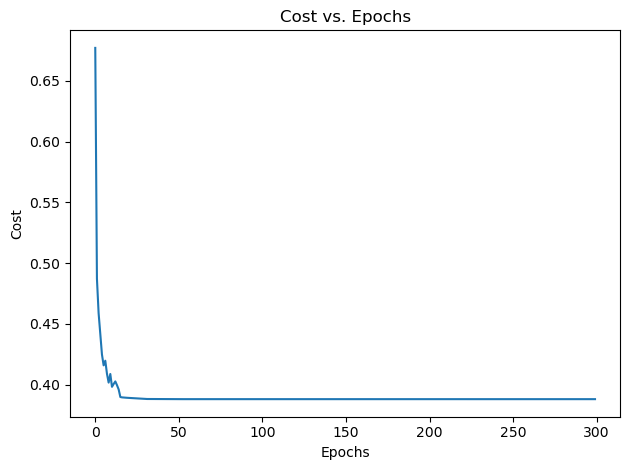

In [33]:
# Plot the cross entropy loss
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.title('Cost vs. Epochs')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

We can also see that the magnitude graph looks as expected; we want the initial magnitudes to be similar and then diverge as the number of layers increases:

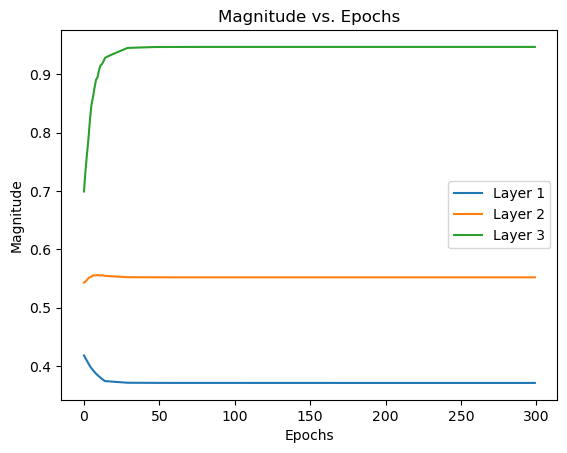

In [34]:
# graph the magnitudes for each layer versus the number of epochs
fig, ax = plt.subplots()
epochs = range(nn.epochs) # use range() to generate a sequence of integers
ax.plot(epochs, nn.mag_1, label='Layer 1')
ax.plot(epochs, nn.mag_2, label='Layer 2')
ax.plot(epochs, nn.mag_3, label='Layer 3')
ax.set_xlabel('Epochs')
ax.set_ylabel('Magnitude')
ax.set_title('Magnitude vs. Epochs')
ax.legend()
plt.show()

Now, let's compare the three layer perceptron to the two layer perceptron:

In [59]:
three_layer_evals = cross_val_score(estimator=nn, X=X_train_smote_norm_enc, y=y_train_smote, scoring=my_scorer, cv=cv)
comparison = compare_models(three_layer_evals, smote_nn_norm_enc_evals)
print(comparison)

(-0.013408089607507164, 0.03977557572090973)


This range includes 0, so we cannot say with 95% confidence that the two layer perceptron vs. three layer perceptrons are statistically different. This makes sense as we already achieved good performance with the two layer perceptron, and the accuracies are extremely close. It's possible that two layers was enough to mostly optimize our performance on this dataset. However, let's keep adding layers and determine if that's true or not.

## Four Layer Perceptron

We will repeat the same steps as above to add a fourth layer:

In [36]:
# create a 4 layer perceptron class
class FourLayerPerceptron(object):
    def __init__(self, n_hidden1=30, n_hidden2=30, n_hidden3=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    def _initialize_weights(self):
        '''Initialize weidhgts with small random numbers'''
        # Layer 1
        W1_num_elems = (self.n_features_)*self.n_hidden1
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden1, self.n_features_)
        b1 = np.zeros((self.n_hidden1, 1))

        # Layer 2
        W2_num_elems = (self.n_hidden1)*self.n_hidden2
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden2, self.n_hidden1)
        b2 = np.zeros((self.n_hidden2, 1))

        # Layer 3
        W3_num_elems = (self.n_hidden2)*self.n_hidden3
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_hidden3, self.n_hidden2)
        b3 = np.zeros((self.n_hidden3, 1))

        # Layer 4
        W4_num_elems = (self.n_hidden3)*self.n_output_
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_output_, self.n_hidden3)
        b4 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, b1, b2, b3, b4
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        return expit(z)
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2))
    
    def _cost(self,A5,Y_enc,W1,W2,W3,W4):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A5)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term
    
    def _feed_forward(self, X, W1, W2, W3, W4, b1, b2, b3, b4):
        '''Compute feedforward step'''
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5
    
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        '''Compute gradient step using backpropagation'''
        # vectorized backpropagation
        V4 = -2*(Y_enc-A5)*A5*(1-A5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4
    
    def predict(self, X):
        '''Predict class labels'''
        _, _, _, _, _, _, _, _, A5 = self._feed_forward(X, self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred

In [37]:
# Four layer perceptron with mini-batch and cooling and cross entropy loss and Glorot initialization
class FourLayerEnhanced(FourLayerPerceptron):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)

    # Glorot initialization
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden1 + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden1, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden2 + self.n_hidden1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden1)) 

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden3 + self.n_hidden2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden3, self.n_hidden2)) 

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden3)) 

        # set these to zero to start so that
        # they do not immediately saturate
        b1 = np.zeros((self.n_hidden1, 1))
        b2 = np.zeros((self.n_hidden2, 1))
        b3 = np.zeros((self.n_hidden3, 1))
        b4 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, b1, b2, b3, b4
    
    # Cross entropy loss
    def _cost(self,A5,Y_enc,W1,W2,W3,W4):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A5+1e-7)+(1-Y_enc)*np.log(1-A5+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term
    
    # Vectorized backpropagation
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        '''Compute gradient step using backpropagation'''
        # vectorized backpropagation
        V4 = (A5-Y_enc)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)

        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)
        rho_W4_prev = np.zeros(self.W4.shape)

        self.cost_ = []
        self.score_ = []

        # keep track of magnitude for each layer
        self.mag_1 = []
        self.mag_2 = []
        self.mag_3 = []
        self.mag_4 = []

        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
        
        for i in range(self.epochs):
                
                # adaptive learning rate
                # decrease at certain epochs
                eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

                if print_progress>0 and (i+1)%print_progress==0:
                    sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                    sys.stderr.flush()

                if self.shuffle:
                    idx_shuffle = np.random.permutation(y_data.shape[0])
                    X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]
                
                mini = np.array_split(range(y_data.shape[0]), self.minibatches)
                mini_cost = []
                for idx in mini:

                    # feedforward
                    A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feed_forward(X_data[idx],
                                                        self.W1,
                                                        self.W2,
                                                        self.W3,
                                                        self.W4,
                                                        self.b1,
                                                        self.b2,
                                                        self.b3,
                                                        self.b4
                                                        )
                    
                    cost = self._cost(A5,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4)
                    mini_cost.append(cost) # this appends cost of mini-batch only

                    # compute gradient via backpropagation
                    gradW1, gradW2, gradW3, gradW4, gradb1, gradb2, gradb3, gradb4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4,
                                                      Y_enc=Y_enc[:, idx],
                                                      W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4)
                    
                    # simple momentum calculations
                    rho_W1, rho_W2, rho_W3, rho_W4 = eta * gradW1, eta * gradW2, eta * gradW3, eta * gradW4
                    self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                    self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                    self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                    self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev))
                    self.b1 -= eta * gradb1
                    self.b2 -= eta * gradb2
                    self.b3 -= eta * gradb3
                    self.b4 -= eta * gradb4

                    # update previous parameters
                    rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev = rho_W1, rho_W2, rho_W3, rho_W4

                # Calculate magnitude of weights for each layer
                self.mag_1.append(np.mean(np.abs(self.W1)))
                self.mag_2.append(np.mean(np.abs(self.W2)))
                self.mag_3.append(np.mean(np.abs(self.W3)))
                self.mag_4.append(np.mean(np.abs(self.W4)))

                self.cost_.append(np.mean(mini_cost))
                self.score_.append(accuracy_score(y_data,self.predict(X_data)))

                # update if a validation set was provided
                if XY_test is not None:
                    yhat = self.predict(X_test)
                    self.val_score_.append(accuracy_score(y_test,yhat))

        return self
    
    # get_params and set_params implemented to allow for usage of sklearn cross-validation functions
    def get_params(self, deep=True):
        return {
            'n_hidden1': self.n_hidden1,
            'n_hidden2': self.n_hidden2,
            'n_hidden3': self.n_hidden3,
            'C': self.l2_C,
            'epochs': self.epochs,
            'eta': self.eta,
            'alpha': self.alpha,
            'decrease_const': self.decrease_const,
            'decrease_iter': self.decrease_iter,
            'minibatches': self.minibatches,
            'shuffle': self.shuffle
        }
    
    def set_params(self, **params):
        # Set the parameters of the estimator
        for param, value in params.items():
            setattr(self, param, value)
        return self
    

In [38]:
vals = { 'n_hidden1':60, 'n_hidden2':44, 'n_hidden3':33,
            'C':0.1, 'epochs':100, 'eta':0.001,
            'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
            'minibatches':50,
            'shuffle':True,'random_state':1}

nn = FourLayerEnhanced(**vals)
%time nn.fit(X_train_smote_norm_enc, y_train_smote, print_progress=10, XY_test=(X_test_norm_enc, y_test))
print_accuracies(nn,X_train_smote_norm_enc,y_train_smote,X_test_norm_enc,y_test)

Epoch: 100/100

CPU times: total: 5min 8s
Wall time: 43.6 s
Resubstitution accuracy: 0.6890818967407992
Validation accuracy: 0.6736798679867987


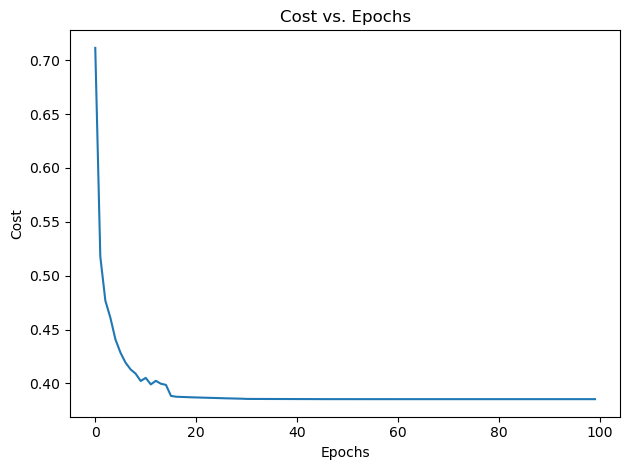

In [39]:
# plot the cross entropy loss
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.title('Cost vs. Epochs')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

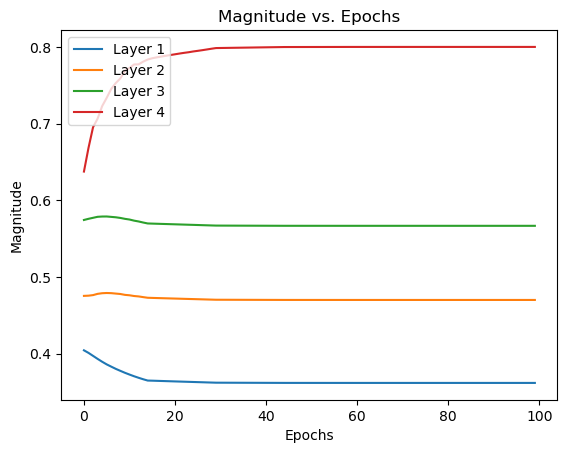

In [40]:
# graph the magnitudes for each layer versus the number of epochs
fig, ax = plt.subplots()
epochs = range(nn.epochs) # use range() to generate a sequence of integers
ax.plot(epochs, nn.mag_1, label='Layer 1')
ax.plot(epochs, nn.mag_2, label='Layer 2')
ax.plot(epochs, nn.mag_3, label='Layer 3')
ax.plot(epochs, nn.mag_4, label='Layer 4')
ax.set_xlabel('Epochs')
ax.set_ylabel('Magnitude')
ax.set_title('Magnitude vs. Epochs')
ax.legend()
plt.show()

In [41]:
# Compare three and four layer perceptron to determine statistical difference
four_layer_evals = cross_val_score(estimator=nn, X=X_train_smote_norm_enc, y=y_train_smote, scoring=my_scorer, cv=cv)
comparison = compare_models(four_layer_evals, three_layer_evals)
print(comparison)

# Compare four layer perceptron to the two layer perceptron
comparison = compare_models(four_layer_evals, smote_nn_norm_enc_evals)
print(comparison)

(-0.026612709414167032, 0.01163608289489076)
(-0.005403953246664624, 0.02968377505824684)


Once again, the training converges, and the magnitudes begin similar and then taper off, with deeper layers having higher magnitudes. The 68% and 67% accuracies may be the best we do; we've added two layers and the accuracy has not gone up, only gone doenw very slightly. Again, 0 is in the range returned by our statistical tests so we can't say that the models are statistically different. This tracks with the accuracies being basically the same as two and three-layer perceptrons.

## Five Layer Perceptron

Finally, we finish adding layers with a 5th layer:

In [42]:
# 5 layer perceptron class
class FiveLayerPerceptron(object):
    def __init__(self, n_hidden1=30, n_hidden2=30, n_hidden3=30, n_hidden4=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.n_hidden4 = n_hidden4
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
    
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    def _initialize_weights(self):
        '''Initialize weidhgts with small random numbers'''
        # Layer 1
        W1_num_elems = (self.n_features_)*self.n_hidden1
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden1, self.n_features_)
        b1 = np.zeros((self.n_hidden1, 1))

        # Layer 2
        W2_num_elems = (self.n_hidden1)*self.n_hidden2
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden2, self.n_hidden1)
        b2 = np.zeros((self.n_hidden2, 1))

        # Layer 3
        W3_num_elems = (self.n_hidden2)*self.n_hidden3
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_hidden3, self.n_hidden2)
        b3 = np.zeros((self.n_hidden3, 1))

        # Layer 4
        W4_num_elems = (self.n_hidden3)*self.n_hidden4
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_hidden4, self.n_hidden3)
        b4 = np.zeros((self.n_hidden4, 1))

        # Layer 5
        W5_num_elems = (self.n_hidden4)*self.n_output_
        W5 = np.random.uniform(-1.0, 1.0, size=W5_num_elems)
        W5 = W5.reshape(self.n_output_, self.n_hidden4)
        b5 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        return expit(z)
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2))
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A6)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    def _feed_forward(self, X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
        '''Compute feedforward step'''
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = self._sigmoid(Z3)
        Z4 = W4 @ A4 + b4
        A5 = self._sigmoid(Z4)
        Z5 = W5 @ A5 + b5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        '''Compute gradient step using backpropagation'''
        # vectorized backpropagation
        V5 = -2*(Y_enc-A6)*A6*(1-A6)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb5 = np.sum(V5, axis=1).reshape((-1,1))
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5
    
    def predict(self, X):
        '''Predict class labels'''
        _, _, _, _, _, _, _, _, _, _, A6 = self._feed_forward(X, self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred


In [43]:
# Five layer perceptron with mini-batch and cooling and cross entropy loss and Glorot initialization
class FiveLayerEnhanced(FiveLayerPerceptron):
    def __init__(self, alpha=0.0, decrease_const=0.1, 
                 decrease_iter = 10, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.decrease_iter = decrease_iter
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
    
    # Glorot initialization
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden1 + self.n_features_))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden1, self.n_features_))

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden2 + self.n_hidden1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden2, self.n_hidden1)) 

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden3 + self.n_hidden2))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden3, self.n_hidden2)) 

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden4 + self.n_hidden3))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden4, self.n_hidden3)) 

        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden4))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden4)) 

        # set these to zero to start so that
        # they do not immediately saturate
        b1 = np.zeros((self.n_hidden1, 1))
        b2 = np.zeros((self.n_hidden2, 1))
        b3 = np.zeros((self.n_hidden3, 1))
        b4 = np.zeros((self.n_hidden4, 1))
        b5 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5
    
    # Cross entropy loss
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A6+1e-7)+(1-Y_enc)*np.log(1-A6+1e-7))))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    
    # Vectorized backpropagation
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        '''Compute gradient step using backpropagation'''
        # vectorized backpropagation
        V5 = (A6-Y_enc)
        V4 = A5*(1-A5)*(W5.T @ V5)
        V3 = A4*(1-A4)*(W4.T @ V4)
        V2 = A3*(1-A3)*(W3.T @ V3)
        V1 = A2*(1-A2)*(W2.T @ V2)

        gradW5 = V5 @ A5.T
        gradW4 = V4 @ A4.T
        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb5 = np.sum(V5, axis=1).reshape((-1,1))
        gradb4 = np.sum(V4, axis=1).reshape((-1,1))
        gradb3 = np.sum(V3, axis=1).reshape((-1,1))
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C
        gradW2 += W2 * self.l2_C
        gradW3 += W3 * self.l2_C
        gradW4 += W4 * self.l2_C
        gradW5 += W5 * self.l2_C

        return gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()

        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)
        rho_W4_prev = np.zeros(self.W4.shape)
        rho_W5_prev = np.zeros(self.W5.shape)

        self.cost_ = []
        self.score_ = []

        # keep track of magnitude for each layer
        self.mag_1 = []
        self.mag_2 = []
        self.mag_3 = []
        self.mag_4 = []
        self.mag_5 = []

        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []
        
        for i in range(self.epochs):
                
                # adaptive learning rate
                # decrease at certain epochs
                eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

                if print_progress>0 and (i+1)%print_progress==0:
                    sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                    sys.stderr.flush()

                if self.shuffle:
                    idx_shuffle = np.random.permutation(y_data.shape[0])
                    X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

                mini = np.array_split(range(y_data.shape[0]), self.minibatches)
                mini_cost = []
                for idx in mini:

                    # feedforward
                    A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feed_forward(X_data[idx],
                                                        self.W1,
                                                        self.W2,
                                                        self.W3,
                                                        self.W4,
                                                        self.W5,
                                                        self.b1,
                                                        self.b2,
                                                        self.b3,
                                                        self.b4,
                                                        self.b5
                                                        )
                    
                    cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                    mini_cost.append(cost)

                    # compute gradient via backpropagation
                    gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                      Y_enc=Y_enc[:, idx],
                                                      W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4,W5=self.W5)
                    
                    # simple momentum calculations
                    rho_W1, rho_W2, rho_W3, rho_W4, rho_W5 = eta * gradW1, eta * gradW2, eta * gradW3, eta * gradW4, eta * gradW5
                    self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                    self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                    self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                    self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev))
                    self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev))
                    self.b1 -= eta * gradb1
                    self.b2 -= eta * gradb2
                    self.b3 -= eta * gradb3
                    self.b4 -= eta * gradb4

                    # update previous parameters
                    rho_W1_prev, rho_W2_prev, rho_W3_prev, rho_W4_prev, rho_W5_prev = rho_W1, rho_W2, rho_W3, rho_W4, rho_W5

                # Calculate magnitude of weights for each layer
                self.mag_1.append(np.mean(np.abs(self.W1)))
                self.mag_2.append(np.mean(np.abs(self.W2)))
                self.mag_3.append(np.mean(np.abs(self.W3)))
                self.mag_4.append(np.mean(np.abs(self.W4)))
                self.mag_5.append(np.mean(np.abs(self.W5)))

                self.cost_.append(np.mean(mini_cost))
                self.score_.append(accuracy_score(y_data,self.predict(X_data)))

                # update if a validation set was provided
                if XY_test is not None:
                    yhat = self.predict(X_test)
                    self.val_score_.append(accuracy_score(y_test,yhat))

        return self
    
    
        # get_params and set_params implemented to allow for usage of sklearn cross-validation functions
    def get_params(self, deep=True):
        return {
            'n_hidden1': self.n_hidden1,
            'n_hidden2': self.n_hidden2,
            'n_hidden3': self.n_hidden3,
            'n_hidden4': self.n_hidden4,
            'C': self.l2_C,
            'epochs': self.epochs,
            'eta': self.eta,
            'alpha': self.alpha,
            'decrease_const': self.decrease_const,
            'decrease_iter': self.decrease_iter,
            'minibatches': self.minibatches,
            'shuffle': self.shuffle
        }
    
    def set_params(self, **params):
        # Set the parameters of the estimator
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [44]:
vals = { 'n_hidden1':60, 'n_hidden2':44, 'n_hidden3':33, 'n_hidden4':26,
            'C':0.1, 'epochs':100, 'eta':0.001,
            'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
            'minibatches':50,
            'shuffle':True,'random_state':1}

fiveLayer_nn = FiveLayerEnhanced(**vals)
%time fiveLayer_nn.fit(X_train_smote_norm_enc, y_train_smote, print_progress=10, XY_test=(X_test_norm_enc, y_test))
print_accuracies(fiveLayer_nn,X_train_smote_norm_enc,y_train_smote,X_test_norm_enc,y_test)

Epoch: 100/100

CPU times: total: 5min 54s
Wall time: 50.9 s
Resubstitution accuracy: 0.6830613677238233
Validation accuracy: 0.6723047304730473


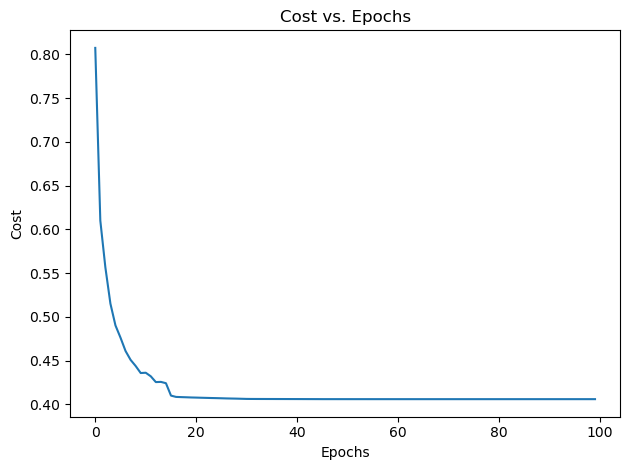

In [45]:
# plot the cross entropy loss
plt.plot(range(len(fiveLayer_nn.cost_)), fiveLayer_nn.cost_)
plt.title('Cost vs. Epochs')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

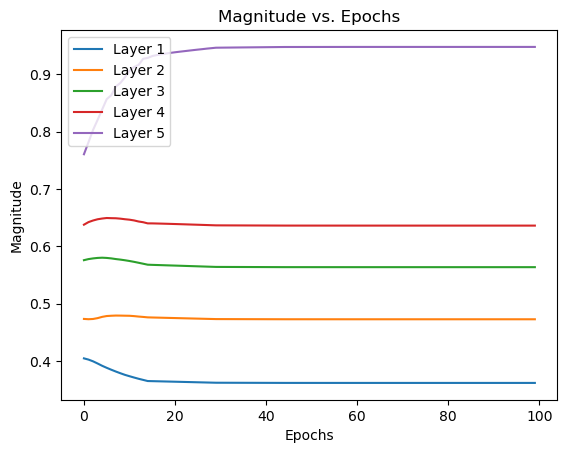

In [46]:
# graph the magnitudes for each layer versus the number of epochs
fig, ax = plt.subplots()
epochs = range(fiveLayer_nn.epochs) # use range() to generate a sequence of integers
ax.plot(epochs, fiveLayer_nn.mag_1, label='Layer 1')
ax.plot(epochs, fiveLayer_nn.mag_2, label='Layer 2')
ax.plot(epochs, fiveLayer_nn.mag_3, label='Layer 3')
ax.plot(epochs, fiveLayer_nn.mag_4, label='Layer 4')
ax.plot(epochs, fiveLayer_nn.mag_5, label='Layer 5')
ax.set_xlabel('Epochs')
ax.set_ylabel('Magnitude')
ax.set_title('Magnitude vs. Epochs')
ax.legend()
plt.show()

In [47]:
# Compare four and five layer perceptron to determine statistical difference
five_layer_evals = cross_val_score(estimator=fiveLayer_nn, X=X_train_smote_norm_enc, y=y_train_smote, scoring=my_scorer, cv=cv)
comparison = compare_models(five_layer_evals, four_layer_evals)
print(comparison)

# Compare five and two layer perceptron
comparison = compare_models(five_layer_evals, smote_nn_norm_enc_evals)
print(comparison)

(-0.009435050922234182, 0.03927831111032197)
(0.0019210500384770415, 0.052202031961192955)


For the five layer perceptron, training converges and the magnitudes check out. There is no statistical difference between the four and five layer perceptrons. However, interestingly this is the first time that we see a statistical difference to the two layer perceptron. Although the accuracies are still basically the same, we finally have a model that we can say with 95% confidence is different from our initial two layer perceptron.

Intuitively, we would think that adding more layers to the percpetron would result in more accurate classification. However, we discussed in class the real possibility that adding more layers might be uneccesary for this dataset. Based on our results, it would indeed seem that two layers got us the best performance we could get thus far. 

## AdaDelta Implementation

Now, we will add AdaDelta as an adaptive learning technnique for our neural network. We hope that this will improve the accuracy of our classification, because adaptive learning techniques can help address problems that occur when training neural networks, such as vanishing or exploding gradients. It should be noted that our initial two-layer perceptron, and all the other perceptrons with 3, 4, and 5 layers, already had adaptive learning implemented. However, we would like to see if using a different technique like AdaDelta results in better performance.

In [48]:
# Extend 5 layer perceptron class to include AdaDelta
class AdaDelta(FiveLayerEnhanced):
    def __init__(self, rho=0.95, epsilon=1e-6, **kwds):
        self.rho = rho
        self.epsilon = epsilon
        super().__init__(**kwds)
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()

        # Initialize AdaDelta variables for each parameter
        E_g2_W1 = np.zeros(self.W1.shape)
        E_g2_W2 = np.zeros(self.W2.shape)
        E_g2_W3 = np.zeros(self.W3.shape)
        E_g2_W4 = np.zeros(self.W4.shape)
        E_g2_W5 = np.zeros(self.W5.shape)
        
        # AdaDelta variables for weight updates
        E_dW1 = np.zeros(self.W1.shape)
        E_dW2 = np.zeros(self.W2.shape)
        E_dW3 = np.zeros(self.W3.shape)
        E_dW4 = np.zeros(self.W4.shape)
        E_dW5 = np.zeros(self.W5.shape)

        self.cost_ = []
        self.score_ = []

        # keep track of magnitude for each layer
        self.mag_1 = []
        self.mag_2 = []
        self.mag_3 = []
        self.mag_4 = []
        self.mag_5 = []

        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))

        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []

        for i in range(self.epochs):
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            
            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []

            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feed_forward(X_data[idx],
                                                    self.W1,
                                                    self.W2,
                                                    self.W3,
                                                    self.W4,
                                                    self.W5,
                                                    self.b1,
                                                    self.b2,
                                                    self.b3,
                                                    self.b4,
                                                    self.b5
                                                    )
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4,W5=self.W5)
                
                # AdaDelta updates for weights and their gradients
                E_g2_W1 = self.rho * E_g2_W1 + (1-self.rho) * gradW1**2
                RMS_dW1 = np.sqrt(E_g2_W1 + self.epsilon)
                delta_W1 = -np.sqrt(E_dW1 + self.epsilon) * gradW1 / RMS_dW1
                E_dW1 = self.rho * E_dW1 + (1-self.rho) * delta_W1**2

                E_g2_W2 = self.rho * E_g2_W2 + (1-self.rho) * gradW2**2
                RMS_dW2 = np.sqrt(E_g2_W2 + self.epsilon)
                delta_W2 = -np.sqrt(E_dW2 + self.epsilon) * gradW2 / RMS_dW2
                E_dW2 = self.rho * E_dW2 + (1-self.rho) * delta_W2**2

                E_g2_W3 = self.rho * E_g2_W3 + (1-self.rho) * gradW3**2
                RMS_dW3 = np.sqrt(E_g2_W3 + self.epsilon)
                delta_W3 = -np.sqrt(E_dW3 + self.epsilon) * gradW3 / RMS_dW3
                E_dW3 = self.rho * E_dW3 + (1-self.rho) * delta_W3**2

                E_g2_W4 = self.rho * E_g2_W4 + (1-self.rho) * gradW4**2
                RMS_dW4 = np.sqrt(E_g2_W4 + self.epsilon)
                delta_W4 = -np.sqrt(E_dW4 + self.epsilon) * gradW4 / RMS_dW4
                E_dW4 = self.rho * E_dW4 + (1-self.rho) * delta_W4**2

                E_g2_W5 = self.rho * E_g2_W5 + (1-self.rho) * gradW5**2
                RMS_dW5 = np.sqrt(E_g2_W5 + self.epsilon)
                delta_W5 = -np.sqrt(E_dW5 + self.epsilon) * gradW5 / RMS_dW5
                E_dW5 = self.rho * E_dW5 + (1-self.rho) * delta_W5**2

                # update weights
                self.W1 += delta_W1
                self.W2 += delta_W2
                self.W3 += delta_W3
                self.W4 += delta_W4
                self.W5 += delta_W5
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                self.b5 -= eta * gradb5
                
            # Calculate magnitude of weights for each layer
            self.mag_1.append(np.mean(np.abs(self.W1)))
            self.mag_2.append(np.mean(np.abs(self.W2)))
            self.mag_3.append(np.mean(np.abs(self.W3)))
            self.mag_4.append(np.mean(np.abs(self.W4)))
            self.mag_5.append(np.mean(np.abs(self.W5)))

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))

        return self
    
    
    def get_params(self, deep=True):
        return {
            'n_hidden1': self.n_hidden1,
            'n_hidden2': self.n_hidden2,
            'n_hidden3': self.n_hidden3,
            'n_hidden4': self.n_hidden4,
            'C': self.l2_C,
            'epochs': self.epochs,
            'eta': self.eta,
            'alpha': self.alpha,
            'decrease_const': self.decrease_const,
            'decrease_iter': self.decrease_iter,
            'minibatches': self.minibatches,
            'shuffle': self.shuffle,
            'rho': self.rho,
            'epsilon': self.epsilon
        }
    
    def set_params(self, **params):
        # Set the parameters of the estimator
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [49]:
vals = { 'n_hidden1':60, 'n_hidden2':44, 'n_hidden3':33, 'n_hidden4':26,
            'C':0.1, 'epochs':100, 'eta':0.001,
            'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
            'minibatches':50,
            'shuffle':True,'random_state':1}

adaDelta_nn = AdaDelta(**vals)
%time adaDelta_nn.fit(X_train_smote_norm_enc, y_train_smote, print_progress=10, XY_test=(X_test_norm_enc, y_test))
print_accuracies(adaDelta_nn,X_train_smote_norm_enc,y_train_smote,X_test_norm_enc,y_test)

Epoch: 100/100

CPU times: total: 5min 52s
Wall time: 50.8 s
Resubstitution accuracy: 0.7222222222222222
Validation accuracy: 0.6465896589658966


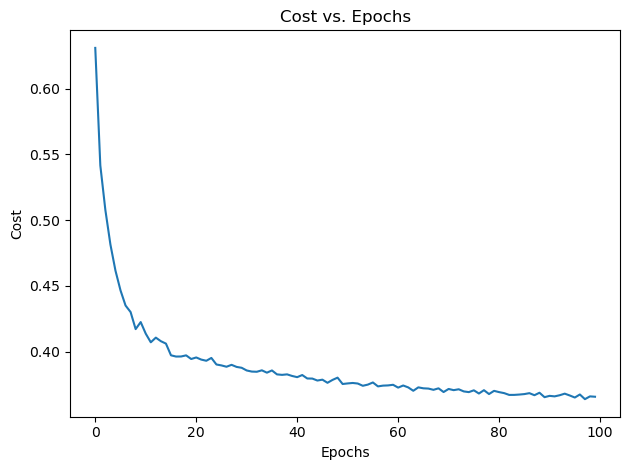

In [50]:
# plot the cross entropy loss
plt.plot(range(len(adaDelta_nn.cost_)), adaDelta_nn.cost_)
plt.title('Cost vs. Epochs')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

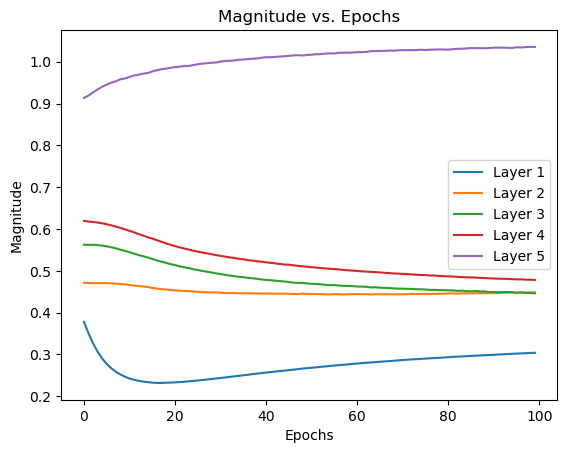

In [51]:
# graph the magnitudes for each layer versus the number of epochs
fig, ax = plt.subplots()
epochs = range(adaDelta_nn.epochs) # use range() to generate a sequence of integers
ax.plot(epochs, adaDelta_nn.mag_1, label='Layer 1')
ax.plot(epochs, adaDelta_nn.mag_2, label='Layer 2')
ax.plot(epochs, adaDelta_nn.mag_3, label='Layer 3')
ax.plot(epochs, adaDelta_nn.mag_4, label='Layer 4')
ax.plot(epochs, adaDelta_nn.mag_5, label='Layer 5')
ax.set_xlabel('Epochs')
ax.set_ylabel('Magnitude')
ax.set_title('Magnitude vs. Epochs')
ax.legend()
plt.show()

In [52]:
# Compare performance between five layer perceptron with and without AdaDelta
adaDelta_evals = cross_val_score(estimator=adaDelta_nn, X=X_train_smote_norm_enc, y=y_train_smote, scoring=my_scorer, cv=cv)
comparison = compare_models(adaDelta_evals, five_layer_evals)
print(comparison)

(-0.09367655399668795, -0.03805308357686979)


There is a statistical difference (with 95% certainty) between the five layer perceptron with and without AdaDelta! The accuracies are different, with a small gain in resubstitution accuracy and a small drop in validation accuracy, so ultimately we don't really have an increase in performance. However, this does show that changing our adaptive learning technique causes our neural network to behave in a significantly different manner. This is what we expected to see; we would hope that changing the internals of the neural network would make it different, and it does.

## AdaM Implementation

Finally, for the exceptional work, we implement AdaM as our adaptive learning technique:

In [53]:
# Extend 5 layer perceptron class to include Adam
class Adam(FiveLayerEnhanced):
    def __init__(self, beta1=0.9, beta2=0.999, epsilon=1e-8, **kwds):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        super().__init__(**kwds)
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5, self.b1, self.b2, self.b3, self.b4, self.b5 = self._initialize_weights()

        # Initialize Adam variables for each parameter
        m_W1 = np.zeros(self.W1.shape)
        m_W2 = np.zeros(self.W2.shape)
        m_W3 = np.zeros(self.W3.shape)
        m_W4 = np.zeros(self.W4.shape)
        m_W5 = np.zeros(self.W5.shape)

        v_W1 = np.zeros(self.W1.shape)
        v_W2 = np.zeros(self.W2.shape)
        v_W3 = np.zeros(self.W3.shape)
        v_W4 = np.zeros(self.W4.shape)
        v_W5 = np.zeros(self.W5.shape)

        self. cost_ = []
        self.score_ = []

        # keep track of magnitude for each layer
        self.mag_1 = []
        self.mag_2 = []
        self.mag_3 = []
        self.mag_4 = []
        self.mag_5 = []

        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))

        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            self.val_cost_ = []

        for i in range(self.epochs):
            eta = self.eta * self.decrease_const**(np.floor(i/self.decrease_iter))

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            
            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []

            for idx in mini:
                # feedforward
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feed_forward(X_data[idx],
                                                    self.W1,
                                                    self.W2,
                                                    self.W3,
                                                    self.W4,
                                                    self.W5,
                                                    self.b1,
                                                    self.b2,
                                                    self.b3,
                                                    self.b4,
                                                    self.b5
                                                    )
                
                cost = self._cost(A6,Y_enc[:, idx],self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradW4, gradW5, gradb1, gradb2, gradb3, gradb4, gradb5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2,W3=self.W3,W4=self.W4,W5=self.W5)
                
                # Adam updates for weights and their gradients
                m_W1 = self.beta1 * m_W1 + (1-self.beta1) * gradW1
                m_W2 = self.beta1 * m_W2 + (1-self.beta1) * gradW2
                m_W3 = self.beta1 * m_W3 + (1-self.beta1) * gradW3
                m_W4 = self.beta1 * m_W4 + (1-self.beta1) * gradW4
                m_W5 = self.beta1 * m_W5 + (1-self.beta1) * gradW5

                v_W1 = self.beta2 * v_W1 + (1-self.beta2) * gradW1**2
                v_W2 = self.beta2 * v_W2 + (1-self.beta2) * gradW2**2
                v_W3 = self.beta2 * v_W3 + (1-self.beta2) * gradW3**2
                v_W4 = self.beta2 * v_W4 + (1-self.beta2) * gradW4**2
                v_W5 = self.beta2 * v_W5 + (1-self.beta2) * gradW5**2

                # Bias correction
                m_W1_hat = m_W1 / (1-self.beta1**(i+1))
                m_W2_hat = m_W2 / (1-self.beta1**(i+1))
                m_W3_hat = m_W3 / (1-self.beta1**(i+1))
                m_W4_hat = m_W4 / (1-self.beta1**(i+1))
                m_W5_hat = m_W5 / (1-self.beta1**(i+1))

                v_W1_hat = v_W1 / (1-self.beta2**(i+1)) 
                v_W2_hat = v_W2 / (1-self.beta2**(i+1))
                v_W3_hat = v_W3 / (1-self.beta2**(i+1))
                v_W4_hat = v_W4 / (1-self.beta2**(i+1))
                v_W5_hat = v_W5 / (1-self.beta2**(i+1))

                # update weights
                self.W1 -= eta * m_W1_hat / (np.sqrt(v_W1_hat) + self.epsilon)
                self.W2 -= eta * m_W2_hat / (np.sqrt(v_W2_hat) + self.epsilon)
                self.W3 -= eta * m_W3_hat / (np.sqrt(v_W3_hat) + self.epsilon)
                self.W4 -= eta * m_W4_hat / (np.sqrt(v_W4_hat) + self.epsilon)
                self.W5 -= eta * m_W5_hat / (np.sqrt(v_W5_hat) + self.epsilon)
                self.b1 -= eta * gradb1
                self.b2 -= eta * gradb2
                self.b3 -= eta * gradb3
                self.b4 -= eta * gradb4
                self.b5 -= eta * gradb5

            # Calculate magnitude of weights for each layer
            self.mag_1.append(np.mean(np.abs(self.W1)))
            self.mag_2.append(np.mean(np.abs(self.W2)))
            self.mag_3.append(np.mean(np.abs(self.W3)))
            self.mag_4.append(np.mean(np.abs(self.W4)))
            self.mag_5.append(np.mean(np.abs(self.W5)))

            self.cost_.append(np.mean(mini_cost))
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))

            # update if a validation set was provided
            if XY_test is not None:
                yhat = self.predict(X_test)
                self.val_score_.append(accuracy_score(y_test,yhat))

        return self
    
    
    def get_params(self, deep=True):
        return {
            'n_hidden1': self.n_hidden1,
            'n_hidden2': self.n_hidden2,
            'n_hidden3': self.n_hidden3,
            'n_hidden4': self.n_hidden4,
            'C': self.l2_C,
            'epochs': self.epochs,
            'eta': self.eta,
            'alpha': self.alpha,
            'decrease_const': self.decrease_const,
            'decrease_iter': self.decrease_iter,
            'minibatches': self.minibatches,
            'shuffle': self.shuffle,
            'epsilon': self.epsilon,
            'beta1': self.beta1,
            'beta2': self.beta2
        }
    
    def set_params(self, **params):
        # Set the parameters of the estimator
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [54]:
vals = { 'n_hidden1':60, 'n_hidden2':44, 'n_hidden3':33, 'n_hidden4':26,
            'C':0.1, 'epochs':100, 'eta':0.001,
            'alpha':0.001, 'decrease_const':0.1, 'decrease_iter':15,
            'minibatches':50,
            'shuffle':True,'random_state':1}

adam_nn = Adam(**vals)
%time adam_nn.fit(X_train_smote_norm_enc, y_train_smote, print_progress=10, XY_test=(X_test_norm_enc, y_test))
print_accuracies(adam_nn,X_train_smote_norm_enc,y_train_smote,X_test_norm_enc,y_test)

Epoch: 100/100

CPU times: total: 5min 53s
Wall time: 52.4 s
Resubstitution accuracy: 0.6300280738693688
Validation accuracy: 0.6803492849284929


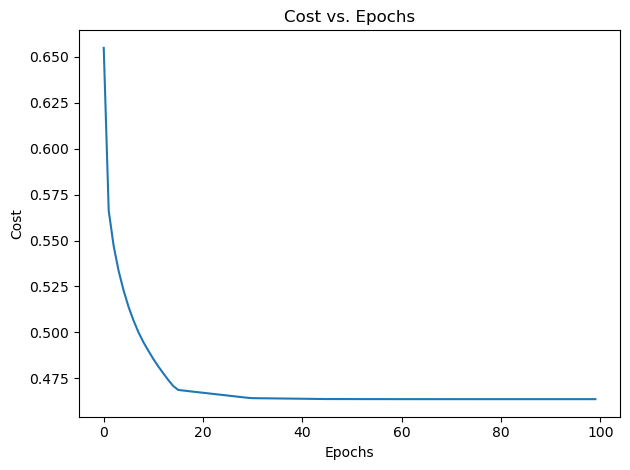

In [55]:
# plot the cross entropy loss
plt.plot(range(len(adam_nn.cost_)), adam_nn.cost_)
plt.title('Cost vs. Epochs')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

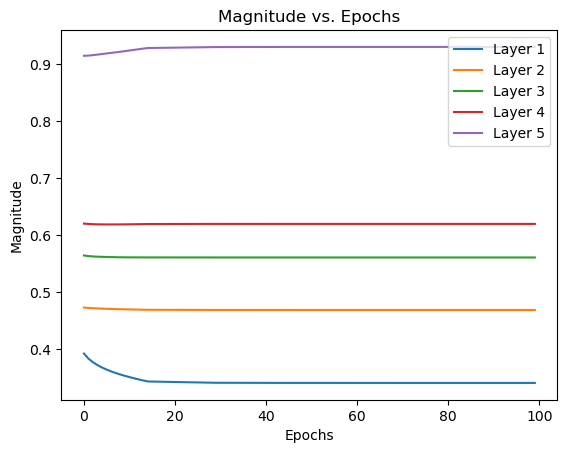

In [56]:
# graph the magnitudes for each layer versus the number of epochs
fig, ax = plt.subplots()
epochs = range(adam_nn.epochs) # use range() to generate a sequence of integers
ax.plot(epochs, adam_nn.mag_1, label='Layer 1')
ax.plot(epochs, adam_nn.mag_2, label='Layer 2')
ax.plot(epochs, adam_nn.mag_3, label='Layer 3')
ax.plot(epochs, adam_nn.mag_4, label='Layer 4')
ax.plot(epochs, adam_nn.mag_5, label='Layer 5')
ax.set_xlabel('Epochs')
ax.set_ylabel('Magnitude')
ax.set_title('Magnitude vs. Epochs')
ax.legend()
plt.show()

In [57]:
# Compare performance between five layer perceptron with different adaptive learning techniques
adam_evals = cross_val_score(estimator=adam_nn, X=X_train_smote_norm_enc, y=y_train_smote, scoring=my_scorer, cv=cv)
comparison = compare_models(adam_evals, adaDelta_evals)
print(comparison)
comparison = compare_models(adam_evals, five_layer_evals)
print(comparison)

(-0.023654374868824067, 0.03045413288455303)
(-0.09334121588545703, -0.031588663672371745)


So there is no statistical difference between using AdaM and AdaDelta, but there is a statistical difference with 95% confidence betewen using AdaM and the original adaptive learning rate present in the base five layer perceptron. Interestingly, the validation accuracy stays roughly the same as before while the resubstitution dropped a fair bit.

Overall, the difference in performance between all of our models are very close. Even the simpler two layer perceptron with no special techniques like AdaDelta or AdaM performs just as well, if not better than the deeper networks and all their bells and whistles.